In [1]:
import torch
import copy
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import corner
from models.my_fair import BinaryFair
from models.flow import Flow
from models.classifier import BinaryClassifier
from utils.StatisticalDistance import EmpiricalStatisticalDistance
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm.auto import trange
from utils.DataSplitting import *

%load_ext autoreload
%autoreload 2

In [2]:
# todo make 6d corner plot for latent space.
# radial latent distance vs label probability?

In [3]:
data_file = torch.load("data/Crime/data.pt")

In [4]:
data = data_file['data']
context = data_file['context']
labels = data_file['labels']

In [5]:
data_train, data_test, context_train, context_test, labels_train, labels_test = train_test_split(data, context, labels, test_size=0.1)
data_train, data_val, context_train, context_val, labels_train, labels_val = train_test_split(data_train, context_train, labels_train, test_size=0.1)

In [6]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True}

# Split data by label
data_0_train = data_train[context_train.flatten()==0]
labels_0_train = labels_train[context_train.flatten()==0]
context_0_train = context_train[context_train.flatten()==0]

data_1_train = data_train[context_train.flatten()==1]
labels_1_train = labels_train[context_train.flatten()==1]
context_1_train = context_train[context_train.flatten()==1]

data_0_test = data_test[context_test.flatten()==0]
labels_0_test = labels_test[context_test.flatten()==0]
context_0_test = context_test[context_test.flatten()==0]

data_1_test = data_test[context_test.flatten()==1]
labels_1_test = labels_test[context_test.flatten()==1]
context_1_test = context_test[context_test.flatten()==1]

data_0_val = data_val[context_val.flatten()==0]
labels_0_val = labels_val[context_val.flatten()==0]
context_0_val = context_val[context_val.flatten()==0]

data_1_val = data_val[context_val.flatten()==1]
labels_1_val = labels_val[context_val.flatten()==1]
context_1_val = context_val[context_val.flatten()==1]

# Generators
label_0_set_train = TensorDataset(data_0_train, labels_0_train, context_0_train)
label_0_generator_train = torch.utils.data.DataLoader(label_0_set_train, **params)

label_1_set_train = TensorDataset(data_1_train, labels_1_train, context_1_train)
label_1_generator_train = torch.utils.data.DataLoader(label_1_set_train, **params)

label_0_set_test = TensorDataset(data_0_test, labels_0_test, context_0_test)
label_0_generator_test = torch.utils.data.DataLoader(label_0_set_test, **params)

label_1_set_test = TensorDataset(data_1_test, labels_1_test, context_1_test)
label_1_generator_test = torch.utils.data.DataLoader(label_1_set_test, **params)

label_0_set_val = TensorDataset(data_0_val, labels_0_val, context_0_val)
label_0_generator_val = torch.utils.data.DataLoader(label_0_set_val, **params)

label_1_set_val = TensorDataset(data_1_val, labels_1_val, context_1_val)
label_1_generator_val = torch.utils.data.DataLoader(label_1_set_val, **params)

In [7]:
#Get label and adversarial accuracy on raw, un-embedded data
data_set_labels_train = TensorDataset(data_train, labels_train.squeeze()) #For label classifier, use data and labels but not context
data_generator_labels_train = torch.utils.data.DataLoader(data_set_labels_train, **params)

data_set_labels_val = TensorDataset(data_val, labels_val.squeeze()) #For label classifier, use data and labels but not context
data_generator_labels_val = torch.utils.data.DataLoader(data_set_labels_val, **params)

data_set_context_train = TensorDataset(data_train, context_train.squeeze()) #For adversairal classifier, use data and context but not labels
data_generator_context_train = torch.utils.data.DataLoader(data_set_context_train, **params)

data_set_context_val = TensorDataset(data_val, context_val.squeeze()) #For adversairal classifier, use data and context but not labels
data_generator_context_val = torch.utils.data.DataLoader(data_set_context_val, **params)

label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
label_classifier.fit(data_generator_labels_train, data_generator_labels_val)

adversarial_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
adversarial_classifier.fit(data_generator_context_train, data_generator_context_val)

baseline_label_acc = label_classifier.accuracy(data_test, labels_test.squeeze())
baseline_adv_acc = adversarial_classifier.accuracy(data_test, context_test.squeeze())

print("Label accuracy:", baseline_label_acc, "Adversarial accuracy:", baseline_adv_acc)

 17%|█▋        | 8499/50000 [00:08<00:41, 997.30it/s] 


Early stopping reached after 17 epochs


 24%|██▍       | 11999/50000 [00:11<00:37, 1011.51it/s]

Early stopping reached after 24 epochs
Label accuracy: 0.8199999928474426 Adversarial accuracy: 0.9750000238418579


In [8]:
probability_flow = Flow(data_dim=data_train.shape[-1], 
                  context_dim=context_train.shape[-1], #for alpha=1 the labels and contexts are the same
                  n_layers = 3,
                  transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', # ? Try Rational quadratic?
                  num_bins = 50,
                  tails='linear',
                  tail_bound=6.0,
        )

In [9]:
tot_loss = probability_flow.fit_prob_flow(
        data_generator_context_train,
        data_generator_context_val,
        lr=1e-4,
        weight_decay=1e-4,
        max_num_epochs=100,
        n_steps_per_epoch=int(1e2),
        patience=10,)

 34%|███▍      | 3399/10000 [00:35<01:09, 95.49it/s] 

Early stopping reached after 34 epochs


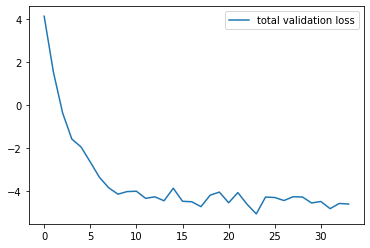

In [10]:
plt.plot(tot_loss, label="total validation loss")

xlims = plt.xlim()
ylims = plt.ylim()
plt.legend()
plt.show()

In [51]:
gamma = 0.9
Fair = BinaryFair(data_dim=data_train.shape[-1], 
                    context_dim=context_train.shape[-1],
                    flow_n_layers = 2,
                    flow_transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 2,
                    classifier_activation = 'ReLU',
                    num_bins = 50,
                    tails='linear',
                    tail_bound=6.0,
                    gamma=gamma
                    )
# optimizer = torch.optim.AdamW(Fair.parameters(), lr=1e-4, weight_decay=1e-4)
total_losses = []
KL_losses = []
clf_losses = []

In [52]:
# fair_loss = Fair.fit(label_0_generator, label_1_generator, probability_flow, n_steps=4000)
fair_loss = Fair.fit(label_0_generator_train, label_1_generator_train, label_0_generator_val, label_1_generator_val, probability_flow, max_num_epochs=100, n_steps_per_epoch=int(1e2), patience=10,) 

 38%|███▊      | 3799/10000 [04:33<07:26, 13.89it/s]

Early stopping reached after 38 epochs


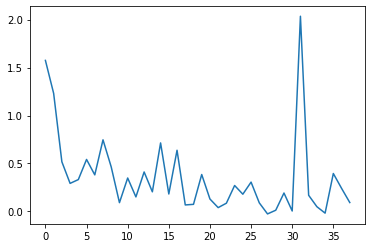

In [53]:
plt.plot(fair_loss, label="fair loss")
# plt.xscale('log')
# plt.yscale('log')

Text(0.5, 1.0, 'Embedding, gamma = 0.9999')

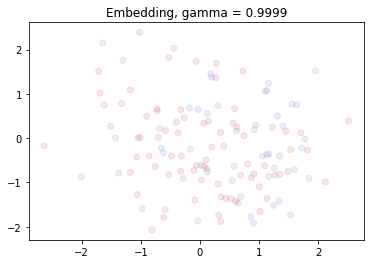

In [89]:
data_0, labels_0, context_0 = next(iter(label_0_generator_test))
data_1, labels_1, context_1 = next(iter(label_1_generator_test))

embedding_0 = Fair._embed(data_0, context_0)
embedding_1 = Fair._embed(data_1, context_1)

plt.scatter(*embedding_0.T[0:2].detach(), alpha=0.1, c=labels_0, cmap='coolwarm')
plt.scatter(*embedding_1.T[0:2].detach(), alpha=0.1, c=labels_1, cmap='coolwarm')

plt.title("Embedding, gamma = " + str(gamma))
# plt.savefig("Figures/embedding_gamma_" + str(gamma) + ".png")

In [90]:
#Look at all data, not just test
idx = (data_file["context"] == 0).flatten()    
embedding_0 = Fair._embed(data_file["data"][idx], data_file["context"][idx])
embedding_1 = Fair._embed(data_file["data"][~idx], data_file["context"][~idx])

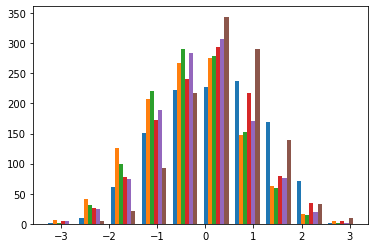

In [91]:
plt.hist(embedding_0.detach().T)
plt.show()

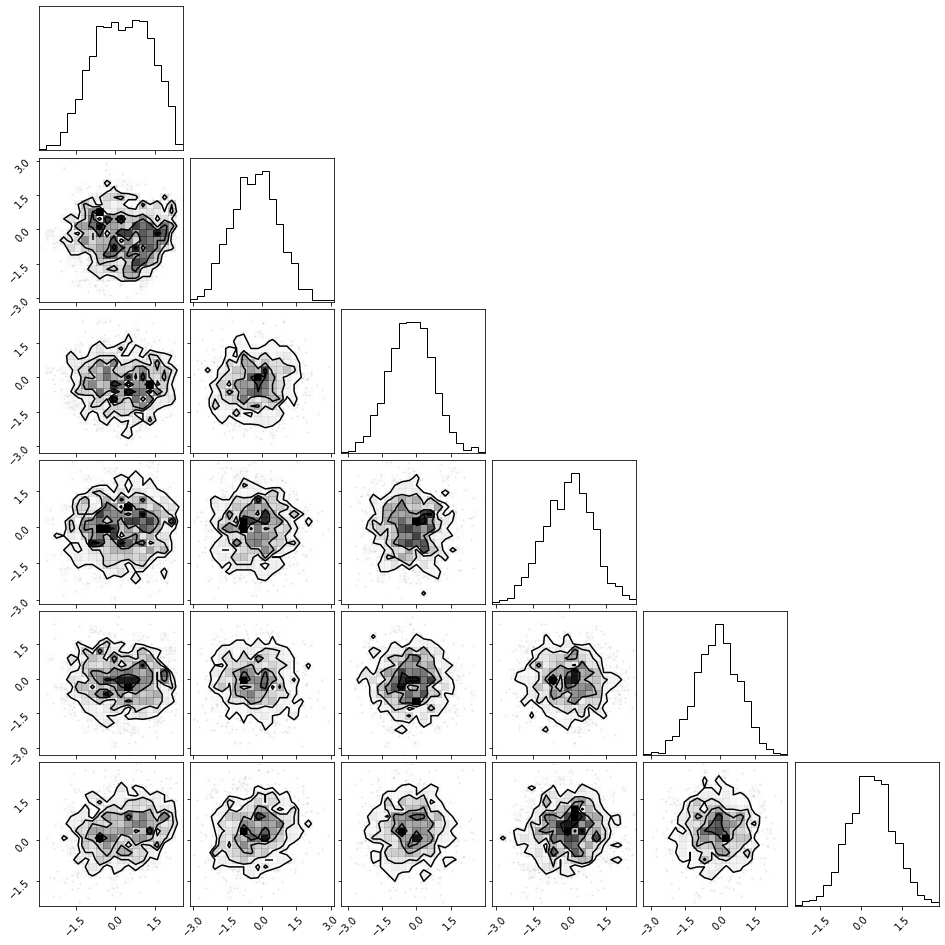

In [92]:
corner_figure = corner.corner(embedding_0.detach().numpy())
# corner_figure.savefig("Figures/corner_gamma_" + str(gamma) + ".png")

In [58]:
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    
    embedding_0 = Fair._embed(data_file["data"][idx], data_file["context"][idx])
    embedding_1 = Fair._embed(data_file["data"][~idx], data_file["context"][~idx])

EmpiricalStatisticalDistance(
    embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100
)


100%|██████████| 100/100 [00:04<00:00, 23.50it/s]

Training set accuracy: 0.785
Test set accuracy: 0.621


0.6211699164345403

In [50]:
#Optimal Adversary
#TODO: need to add the context to the data
# idx = (data_file["context"] == 0).flatten()
# data_0 = data_file["data"][idx]
# data_1 = data_file["data"][~idx]
# context_0 = data_file["context"][idx]
# context_1 = data_file["context"][~idx]
data_0, labels_0, context_0 = next(iter(label_0_generator_train))
data_1, labels_1, context_1 = next(iter(label_1_generator_train))

# mu_star_0_avg, mu_star_1_avg, stat_dist, logP_Z0_z0, logP_Z1_z1, logP_Z0_z1, logP_Z1_z0 = Fair.optimal_adversary(data_0, data_1, context_0=context_0, context_1=context_1, probability_flow=probability_flow)
stat_dist, mu_star_0, mu_star_1, = Fair.optimal_adversary(label_0_generator_train, label_1_generator_train, probability_func=probability_flow)


In [62]:
stat_dist, mu_star_0.float().mean(), mu_star_1.float().mean()

(tensor(-0.3906), tensor(0.3438), tensor(0.7344))

gamma: 0.01 mu_star_0_avg: tensor(0.1875) mu_star_1_ave: tensor(0.8750) stat_dist: tensor(-0.6875)

gamma: 0.9 mu_star_0_avg: tensor(0.2812) mu_star_1_ave: tensor(0.5938) stat_dist: tensor(-0.3125)

In [83]:
gammas = [0.0, 0.2, 0.7, 0.9, 0.99, 1 - 1e-4]
Fairs = []

In [84]:
for gamma in gammas:
    Fair = BinaryFair(data_dim=data_train.shape[-1], 
                    context_dim=context_train.shape[-1],
                    flow_n_layers = 2,
                    flow_transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 2,
                    classifier_activation = 'ReLU',
                    num_bins = 50,
                    tails='linear',
                    tail_bound=6.0,
                    gamma=gamma
                    )
    fair_loss = Fair.fit(label_0_generator_train, label_1_generator_train, label_0_generator_val, label_1_generator_val, probability_flow, max_num_epochs=100, n_steps_per_epoch=int(1e2), patience=10,) 


    Fairs.append(Fair)


 12%|█▏        | 1199/10000 [00:12<01:29, 98.30it/s] 


Early stopping reached after 12 epochs


 20%|█▉        | 1999/10000 [02:23<09:33, 13.95it/s]


Early stopping reached after 20 epochs


 40%|███▉      | 3999/10000 [04:44<07:07, 14.05it/s]


Early stopping reached after 40 epochs


 36%|███▌      | 3599/10000 [04:25<07:51, 13.58it/s]


Early stopping reached after 36 epochs


 30%|██▉       | 2999/10000 [03:35<08:24, 13.89it/s]


Early stopping reached after 30 epochs


 28%|██▊       | 2799/10000 [03:22<08:39, 13.85it/s]

Early stopping reached after 28 epochs


In [85]:
data_0_test, labels_0_test, context_0_test = next(iter(label_0_generator_test))
data_1_test, labels_1_test, context_1_test = next(iter(label_1_generator_test))
stat_dists=[]
mu0s_arr=[]
mu1s_arr=[]

for fair in Fairs:
    stat_dist, mu0s, mu1s = fair.optimal_adversary(label_0_generator_test, label_1_generator_test,probability_func=probability_flow)
    mu0s_arr.append(mu0s.sum().item()/len(mu0s))
    mu1s_arr.append(mu1s.sum().item()/len(mu1s))
    stat_dists.append(abs(stat_dist.item()))
print(stat_dists)

[1.0, 0.546875, 0.015625, 0.125, 0.0, 0.15625]


In [86]:
accs = []
for fair in Fairs:
    with torch.no_grad():
        idx = (data_file["context"] == 0).flatten()
        embedding_0 = fair._embed(data_file["data"][idx], data_file["context"][idx])
        embedding_1 = fair._embed(data_file["data"][~idx], data_file["context"][~idx])

    acc_test = EmpiricalStatisticalDistance(
        embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=500, report_accuracy=True
    )
    accs.append(acc_test)

100%|██████████| 500/500 [00:22<00:00, 22.63it/s]


Training set accuracy: 1.000
Test set accuracy: 1.000


100%|██████████| 500/500 [00:21<00:00, 23.74it/s]


Training set accuracy: 1.000
Test set accuracy: 0.804


100%|██████████| 500/500 [00:21<00:00, 23.09it/s]


Training set accuracy: 1.000
Test set accuracy: 0.572


100%|██████████| 500/500 [00:22<00:00, 22.66it/s]


Training set accuracy: 1.000
Test set accuracy: 0.575


100%|██████████| 500/500 [00:22<00:00, 22.53it/s]


Training set accuracy: 1.000
Test set accuracy: 0.617


100%|██████████| 500/500 [00:21<00:00, 23.22it/s]

Training set accuracy: 1.000
Test set accuracy: 0.588


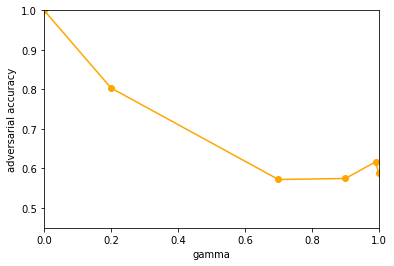

In [87]:
plt.plot(gammas, accs, '-o', color='orange')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('gamma')
plt.ylabel('adversarial accuracy')
plt.show()

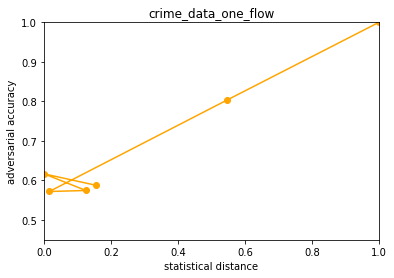

In [93]:
plt.plot(stat_dists, accs, '-o', color='orange')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('statistical distance')
plt.ylabel('adversarial accuracy')
plt.title('crime_data_one_flow')
plt.savefig('crime_data_one_flow.png')
plt.show()


add validation set (both to probability flow and FAIR)
85, 10, 5

Check classifier accuracy (separate generation from analysis)
torch.save model
torch.load model
rewrite splitting
save probability flow separately

In [94]:
embedded_label_accs = []
adversary_accs = []
for fair in Fairs:

    # embedding_context_generator, embedding_labels_generator, embedding_data_test, embedding_context_test, embedding_labels_test = get_embedding_data(data_train, labels_train.squeeze(), context_train.squeeze(), data_test, labels_test.squeeze(), context_test.squeeze(), fair)
    embedding_context_generator_train, embedding_labels_generator_train, embedding_context_generator_val, embedding_labels_generator_val, embedding_data_test, embedding_context_test, embedding_labels_test = get_embedding_data(data_train, labels_train.squeeze(), context_train.squeeze(), data_val, labels_val.squeeze(), context_val.squeeze(), data_test, labels_test.squeeze(), context_test.squeeze(), fair)

    adv_classifier = BinaryClassifier(data_dim=data_train.shape[-1])    
    adv_classifier.fit(embedding_context_generator_train,embedding_context_generator_val )
    
    embedded_label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
    embedded_label_classifier.fit(embedding_labels_generator_train, embedding_labels_generator_val)

    embedded_label_accs.append(embedded_label_classifier.accuracy(embedding_data_test, embedding_labels_test))
    adversary_accs.append(adv_classifier.accuracy(embedding_data_test, embedding_context_test))


 50%|████▉     | 24999/50000 [00:20<00:20, 1196.50it/s]


Early stopping reached after 50 epochs


 12%|█▏        | 5999/50000 [00:05<00:38, 1145.58it/s]


Early stopping reached after 12 epochs


 23%|██▎       | 11499/50000 [00:09<00:33, 1160.52it/s]


Early stopping reached after 23 epochs


 19%|█▉        | 9499/50000 [00:08<00:34, 1178.82it/s]


Early stopping reached after 19 epochs


 28%|██▊       | 13999/50000 [00:12<00:31, 1148.26it/s]


Early stopping reached after 28 epochs


 13%|█▎        | 6499/50000 [00:05<00:37, 1166.41it/s]


Early stopping reached after 13 epochs


 22%|██▏       | 10999/50000 [00:09<00:32, 1192.85it/s]


Early stopping reached after 22 epochs


 23%|██▎       | 11499/50000 [00:09<00:32, 1180.99it/s]


Early stopping reached after 23 epochs


 31%|███       | 15499/50000 [00:13<00:29, 1153.90it/s]


Early stopping reached after 31 epochs


 26%|██▌       | 12999/50000 [00:11<00:31, 1173.48it/s]


Early stopping reached after 26 epochs


 21%|██        | 10499/50000 [00:08<00:32, 1199.86it/s]


Early stopping reached after 21 epochs


 13%|█▎        | 6499/50000 [00:05<00:37, 1154.67it/s]

Early stopping reached after 13 epochs


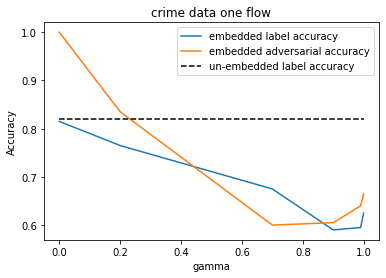

In [95]:
plt.plot(gammas, embedded_label_accs, label='embedded label accuracy')
plt.plot(gammas, adversary_accs, label='embedded adversarial accuracy')
plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_label_acc, 'k--', label='un-embedded label accuracy')


plt.xlabel('gamma')
plt.ylabel('Accuracy')
plt.title('crime data one flow')
plt.legend()
# plt.savefig('single_flow_crime_accuracy.png')
plt.show()